# Regression in Zero Shot Classification

Licong proposed to add an extra vector in the zero shot classfication and check if the similarity learned from CLIP is biased for the current evaluation set. Here we use the imagenet-1k's eval set.

In [1]:
import torch 

# Load the saved dataloader and logits
model_name = 'ViT-B-32-quickgelu'
model_name = 'ViT-H-14-378-quickgelu'
logits = torch.load(f'./data/total_logits_{model_name}.pt')
device = logits.device
targets = torch.load(f'./data/total_targets_{model_name}.pt')

# Compute the accuracy

with torch.no_grad(): # No need to track gradients for accuracy calculation
    # Get the index of the max logit score (predicted class)
    _, predicted_classes = torch.max(logits, dim=1)

    # Compare predicted classes with the true targets
    correct_predictions = (predicted_classes == targets)

    # Calculate the mean accuracy
    top1_accuracy = correct_predictions.float().mean()
    print(f"\nTop-1 Accuracy: {top1_accuracy.item():.4f}")
    
print(logits.shape)
print(targets.shape)


Top-1 Accuracy: 0.8436
torch.Size([50000, 1000])
torch.Size([50000])


## Part 1: Regression on the whole eval set
We do regression on the whole eval set and check if the vector is close to zero. 

In [33]:
import torch.nn as nn 

def regression(logits, targets, max_iter=100000, lr=1.5, log_iter=1000, verbose=True, init_weight=None):

    # check the shape and device
    assert logits.shape[0] == targets.shape[0], "The number of logits and targets should be the same" 
    assert logits.device == targets.device, "The device of logits and targets should be the same" 

    # Record the loss, max, and accuracy
    loss_his = torch.zeros(max_iter)
    max_his = torch.zeros(max_iter//log_iter) 
    acc_his = torch.zeros(max_iter//log_iter)

    # Initialize the parameter outside the loop to avoid reinitialization in each iteration
    param = nn.Linear(logits.shape[1], 1).to(logits.device)
    # Add a mask to make the first component of param.weight zero
    # Create a mask that will zero out the first component during optimization
    mask = torch.ones(1,logits.shape[1]).to(logits.device)
    mask[0, 0] = 0  # Set the first component to zero
    if init_weight is not None:
        param.weight.data = torch.tensor(init_weight).to(logits.device)
    # param.weight.data = param.weight.data 
    loss_fn = nn.CrossEntropyLoss()

    for iter in range(max_iter):
        # Compute the output
        output = loss_fn(logits + param.weight*mask, targets)
        
        # Compute gradients
        param.zero_grad()  # Clear previous gradients
        output.backward()  # Backpropagation

        loss_his[iter] = output.item()
        # Update parameters
        with torch.no_grad():
            param.weight -= lr * param.weight.grad
            # param.weight -= torch.min(param.weight)  # Ensure non-negative weights
        
        if iter % log_iter == 0:
            # top 1-acc
            _, pred = torch.max(logits + param.weight, 1)
            acc = (pred == targets).float().mean()
            max_his[iter//log_iter] = param.weight.max().item()
            acc_his[iter//log_iter] = acc.item()
            if verbose:
                print(f"Iteration {iter}: Loss = {output.item()}, std = {param.weight.std().item()}, min = {param.weight.min().item()}, max = {param.weight.max().item()}, acc = {acc.item()}")
        
    
    res = {
        'loss_his': loss_his.cpu().detach().numpy(),
        'max_his': max_his.cpu().detach().numpy(),
        'acc_his': acc_his.cpu().detach().numpy(),
        'param': param.weight.cpu().detach().numpy()
    }
    return res


In [ ]:
lr = 1.5
max_iter = 100000
log_iter = 1000
res = regression(logits, targets,max_iter=max_iter, lr=lr, log_iter=log_iter, verbose=True)


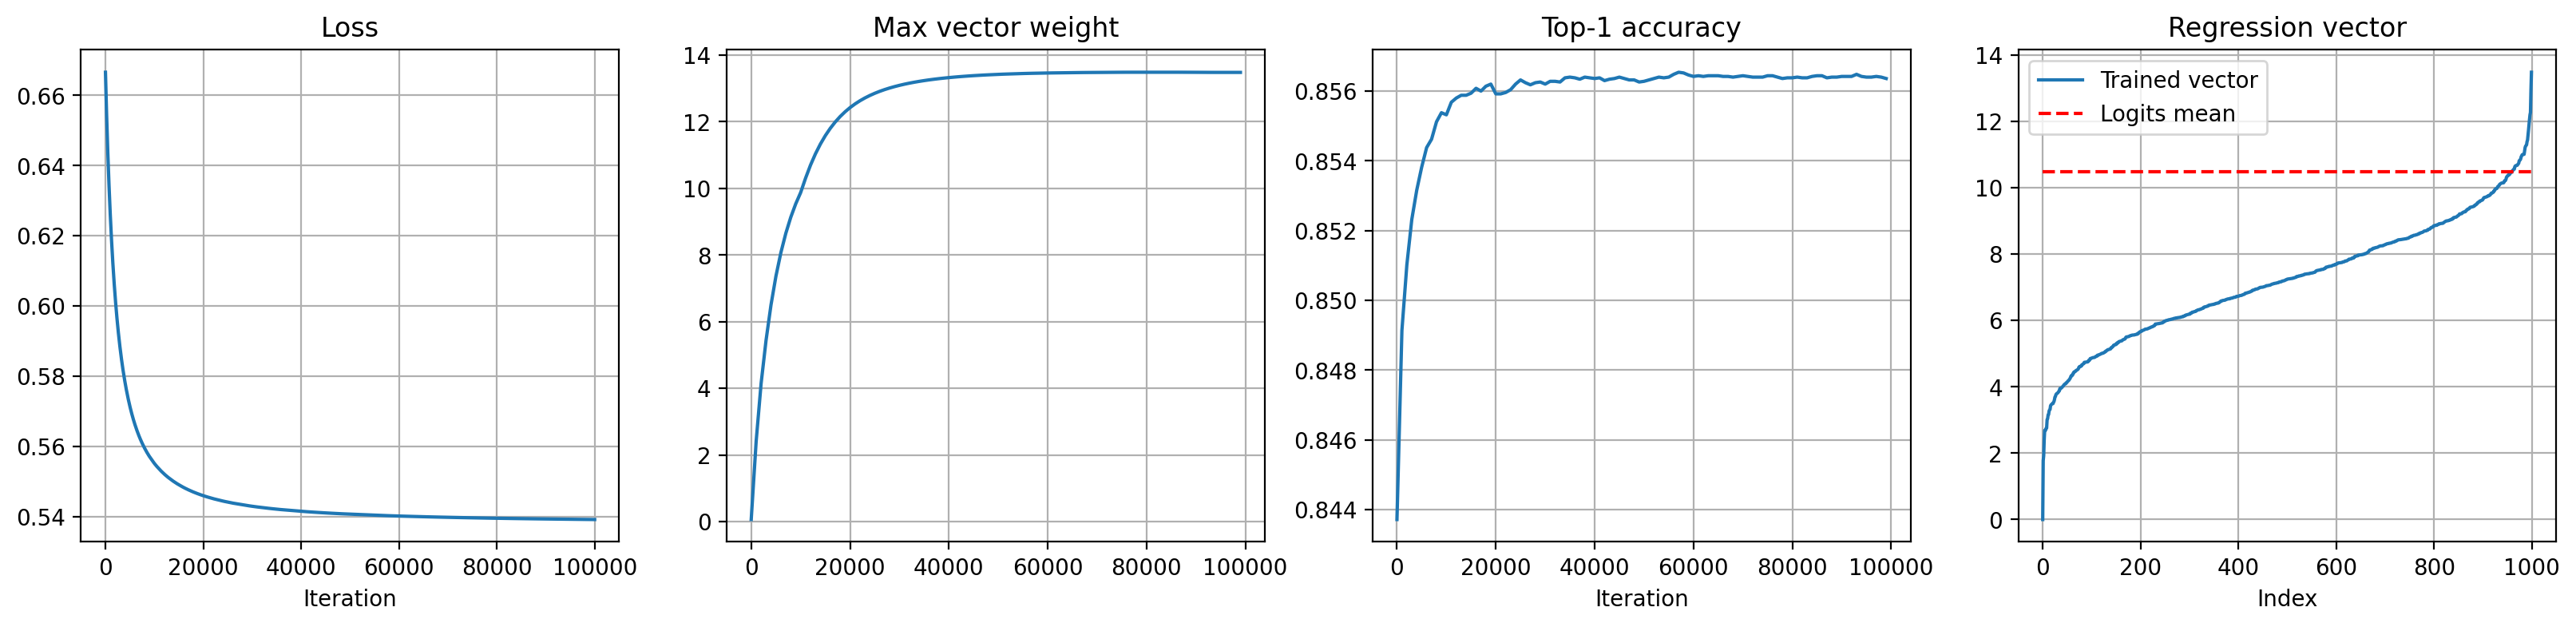

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,4,1)
plt.plot(res['loss_his'])
plt.grid()
plt.title('Loss')
plt.xlabel('Iteration')
max_iter = 100000
log_iter = 1000
plt.subplot(1,4,2)
log_iters = torch.arange(0, max_iter, log_iter)
plt.plot(log_iters,res['max_his'])
plt.grid()
plt.title('Max vector weight')
plt.subplot(1,4,3)
plt.plot(log_iters,res['acc_his'])
plt.grid()
plt.title('Top-1 accuracy')
plt.xlabel('Iteration')
plt.subplot(1,4,4)
plt.plot(np.sort(res['param'][0]),label="Trained vector")
plt.hlines(torch.mean(logits).cpu().detach().numpy(), 0, logits.shape[1], colors='r', linestyles='dashed',label="Logits mean")
plt.grid()
plt.title('Regression vector')
plt.xlabel('Index')
plt.legend()
plt.show()


In [59]:
import numpy as np
import scipy
import scipy.optimize
import scipy.special

def regression_scipy(logits, targets, max_iter=100000, log_iter=1000, verbose=True, init_weight=None):
    """
    Performs regression using scipy.optimize.minimize to find weights
    that minimize cross-entropy loss, with the constraint that the first weight is zero.
    """
    # Convert tensors to NumPy
    logits_np = logits.cpu().detach().numpy()
    targets_np = targets.cpu().detach().numpy()
    N, D = logits_np.shape

    # Objective function (Cross-Entropy Loss)
    def objective(w_reduced, logits_np, targets_np):
        # Add zero as first weight
        w_full = np.concatenate(([0], w_reduced))
        scores = logits_np + w_full
        # Calculate softmax cross-entropy loss
        log_softmax_scores = scores - scipy.special.logsumexp(scores, axis=1, keepdims=True)
        loss = -np.sum(log_softmax_scores[np.arange(N), targets_np]) / N
        return loss
    
    # For tracking progress
    loss_history = []
    acc_history = []
    max_weight_history = []
    iteration_count = [0]  # Using list to allow modification in callback
    
    # Callback function to log progress
    def callback(xk):
        iteration_count[0] += 1
        if iteration_count[0] % log_iter == 0 or iteration_count[0] == 1:
            w_full = np.concatenate(([0], xk))
            current_loss = objective(xk, logits_np, targets_np)
            scores = logits_np + w_full
            pred = np.argmax(scores, axis=1)
            current_acc = np.mean(pred == targets_np)
            max_weight = np.max(np.abs(w_full))
            
            loss_history.append(current_loss)
            acc_history.append(current_acc)
            max_weight_history.append(max_weight)
            
            if verbose:
                print(f"Iteration {iteration_count[0]}: Loss = {current_loss:.6f}, Accuracy = {current_acc:.4f}, Max Weight = {max_weight:.4f}")
            
        return False  # Continue optimization

    # Initial weights (excluding the first one which is fixed at zero)
    if init_weight is not None:
        w0_reduced = np.array(init_weight, dtype=np.float64)[1:]
    else:
        w0_reduced = np.zeros(D - 1, dtype=np.float64)

    if verbose:
        print("Starting optimization...")

    # Optimize using L-BFGS-B
    result = scipy.optimize.minimize(
        objective,
        w0_reduced,
        args=(logits_np, targets_np),
        method='L-BFGS-B',
        options={'maxiter': max_iter, 'disp': verbose},
        callback=callback
    )

    if verbose:
        print(f"Optimization finished: Success={result.success}")

    # Get the full weight vector with first weight as zero
    optimized_weights_full = np.concatenate(([0], result.x))

    # Calculate final metrics
    final_loss = objective(result.x, logits_np, targets_np)
    final_scores = logits_np + optimized_weights_full
    final_pred = np.argmax(final_scores, axis=1)
    final_acc = np.mean(final_pred == targets_np)

    if verbose:
        print(f"Final Loss = {final_loss}, Final Accuracy = {final_acc}")

    return {
        'loss': final_loss,
        'acc': final_acc,
        'param': optimized_weights_full,
        'scipy_result': result,
        'loss_his': loss_history,
        'acc_his': acc_history,
        'max_his': max_weight_history
    }

In [61]:

max_iter = 10
log_iter = 1
lr = 1.5

# res1 = regression(logits_1, targets_1, max_iter=max_iter, lr=lr, log_iter=log_iter, verbose=True)
# res2 = regression(logits_2, targets_2, max_iter=max_iter, lr=lr, log_iter=log_iter, verbose=True)

res1 = regression_scipy(logits_1, targets_1, max_iter=max_iter, log_iter=log_iter, verbose=True)
res2 = regression_scipy(logits_2, targets_2, max_iter=max_iter, lr=lr, log_iter=log_iter, verbose=True) 


Starting optimization...


KeyboardInterrupt: 

## Part 2: Regression on the split eval set 
In this part, we split the data into two splits randomly. We ensure that they have the same size.

In [41]:
torch.manual_seed(0)
# Create empty lists to store indices for each target class
split_1_indices = []
split_2_indices = []

# For each target class (0-999)
for target in range(1000):
    # Get indices for this target class
    target_indices = torch.where(targets == target)[0]
    # # Shuffle these indices
    # shuffled_indices = target_indices[torch.randperm(len(target_indices))]
    # # Split equally
    # half_point = len(shuffled_indices) // 2
    # # Add to respective splits
    # split_1_indices.append(shuffled_indices[:half_point])
    # split_2_indices.append(shuffled_indices[half_point:])

    # Bootstrap 
    shuffle_indices1 = torch.randperm(len(target_indices))
    shuffle_indices2 = torch.randperm(len(target_indices))
    split_1_indices.append(target_indices[shuffle_indices1[:len(target_indices)//2]])
    split_2_indices.append(target_indices[shuffle_indices2[len(target_indices)//2:]])

# Concatenate all indices for each split
split_1 = torch.cat(split_1_indices)
split_2 = torch.cat(split_2_indices)

# Get the corresponding logits and targets
logits_1 = logits[split_1]
logits_2 = logits[split_2]
targets_1 = targets[split_1]
targets_2 = targets[split_2]

print(logits_1.shape)
print(logits_2.shape)
print(targets_1.shape)
print(targets_2.shape)
print(torch.sum(targets_1==0))
print(torch.sum(targets_2==0))


torch.Size([25000, 1000])
torch.Size([25000, 1000])
torch.Size([25000])
torch.Size([25000])
tensor(25, device='cuda:0')
tensor(25, device='cuda:0')


In [38]:
init_weight1 = torch.zeros([1,1000])
init_weight2 = torch.randn([1,1000])*3

max_iter = 50000
log_iter = 5000 
lr = 1.5
res3 = regression(logits_1, targets_1, max_iter=max_iter, lr=lr, log_iter=log_iter, verbose=True, init_weight=init_weight1)
res4 = regression(logits_1, targets_1, max_iter=max_iter, lr=lr, log_iter=log_iter, verbose=True, init_weight=init_weight2)


/tmp/ipykernel_1283/4158805498.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.weight.data = torch.tensor(init_weight).to(logits.device)


Iteration 0: Loss = 0.6727533340454102, std = 0.00030059157870709896, min = -0.0014335379237309098, max = 0.0013442985946312547, acc = 0.8419599533081055
Iteration 5000: Loss = 0.5693849325180054, std = 0.8153166770935059, min = -3.468815326690674, max = 3.8325140476226807, acc = 0.8524399995803833
Iteration 10000: Loss = 0.551824688911438, std = 1.1279460191726685, min = -4.663679599761963, max = 4.7649431228637695, acc = 0.8541199564933777
Iteration 15000: Loss = 0.5450772047042847, std = 1.3054083585739136, min = -5.479795455932617, max = 5.362130165100098, acc = 0.8545999526977539
Iteration 20000: Loss = 0.5415602326393127, std = 1.4263572692871094, min = -5.932534694671631, max = 5.616479396820068, acc = 0.8545199632644653
Iteration 25000: Loss = 0.5394414663314819, std = 1.5160893201828003, min = -6.175704002380371, max = 5.761112213134766, acc = 0.8547599911689758
Iteration 30000: Loss = 0.538034975528717, std = 1.5862406492233276, min = -6.30008602142334, max = 5.86197090148925

In [30]:
print(res3['param'][0,:10])
print(res4['param'][0,:10])

[4.411862  4.3943267 4.130051  4.161477  5.0415983 7.0984674 3.8707151
 5.007409  4.7472944 4.7325883]
[6.9026036 5.9371977 4.055425  4.757474  6.4380727 7.2609286 4.006095
 8.235288  7.88271   5.459881 ]


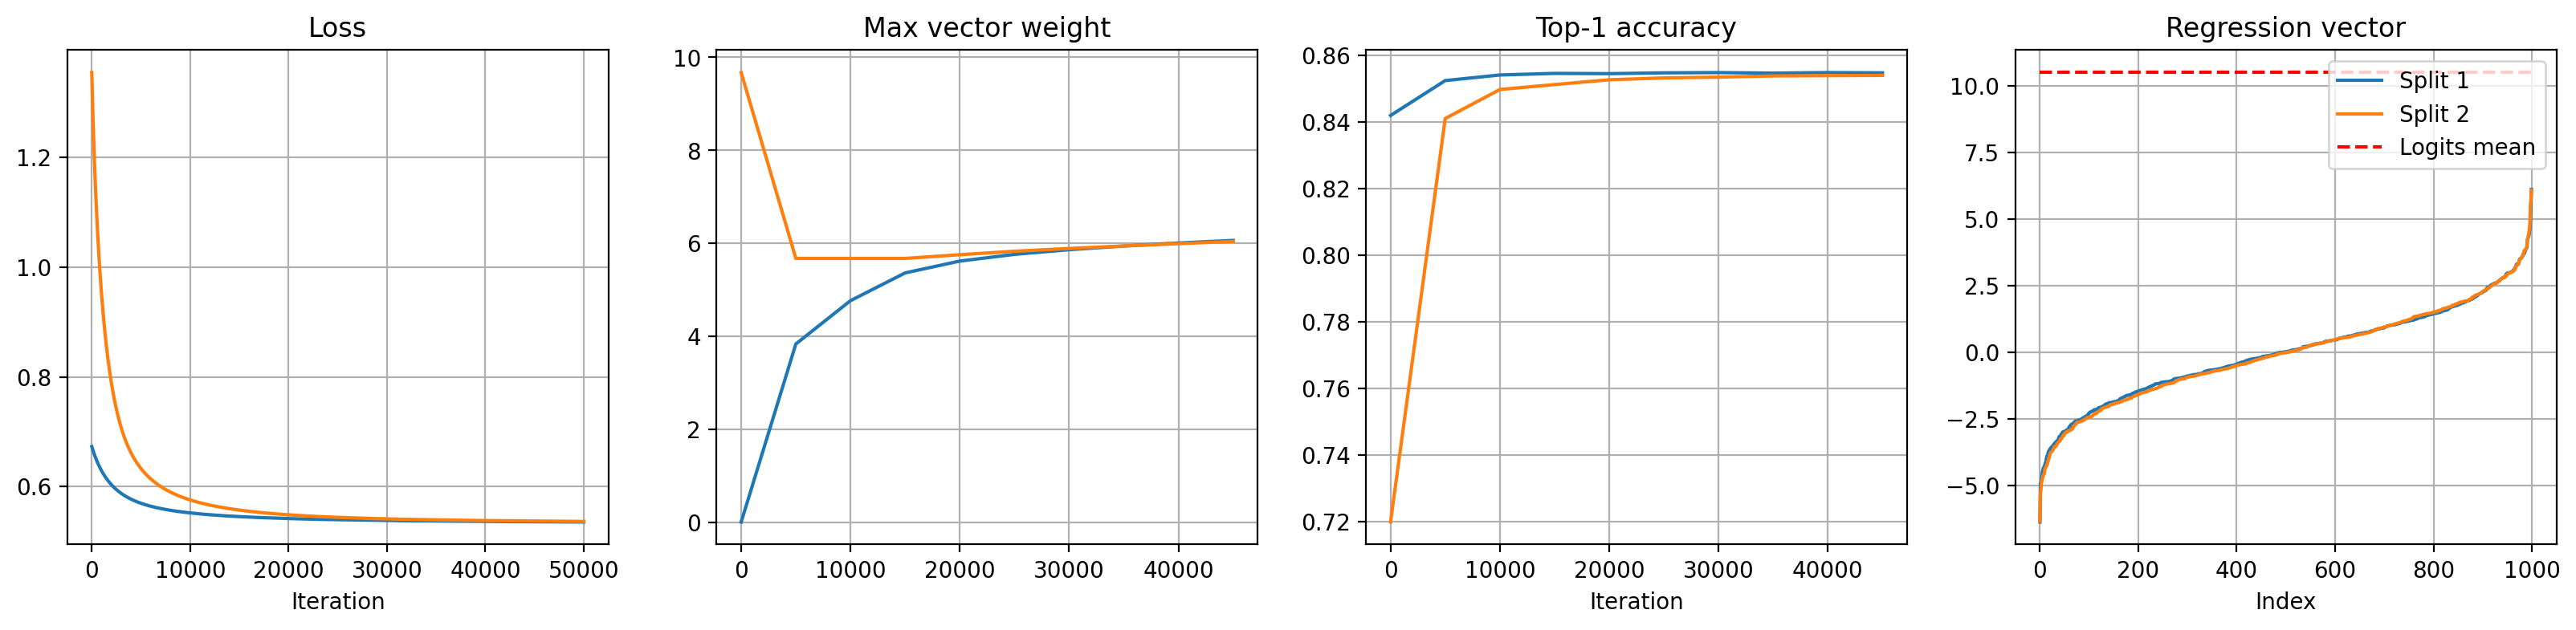

In [39]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,4,1)
plt.plot(res3['loss_his'])
plt.plot(res4['loss_his'])
plt.grid()
plt.title('Loss')
plt.xlabel('Iteration')
plt.subplot(1,4,2)
log_iters = torch.arange(0, max_iter, log_iter)
plt.plot(log_iters,res3['max_his'])
plt.plot(log_iters,res4['max_his'])
plt.grid()
plt.title('Max vector weight')
plt.subplot(1,4,3)
plt.plot(log_iters,res3['acc_his'])
plt.plot(log_iters,res4['acc_his'])
plt.grid()
plt.title('Top-1 accuracy')
plt.xlabel('Iteration')
plt.subplot(1,4,4)
plt.plot(np.sort(res3['param'][0]),label="Split 1")
plt.plot(np.sort(res4['param'][0]),label="Split 2")
plt.hlines(torch.mean(logits).cpu().detach().numpy(), 0, logits.shape[1], colors='r', linestyles='dashed',label="Logits mean")
plt.grid()
plt.title('Regression vector')
plt.xlabel('Index')
plt.legend()
plt.show()

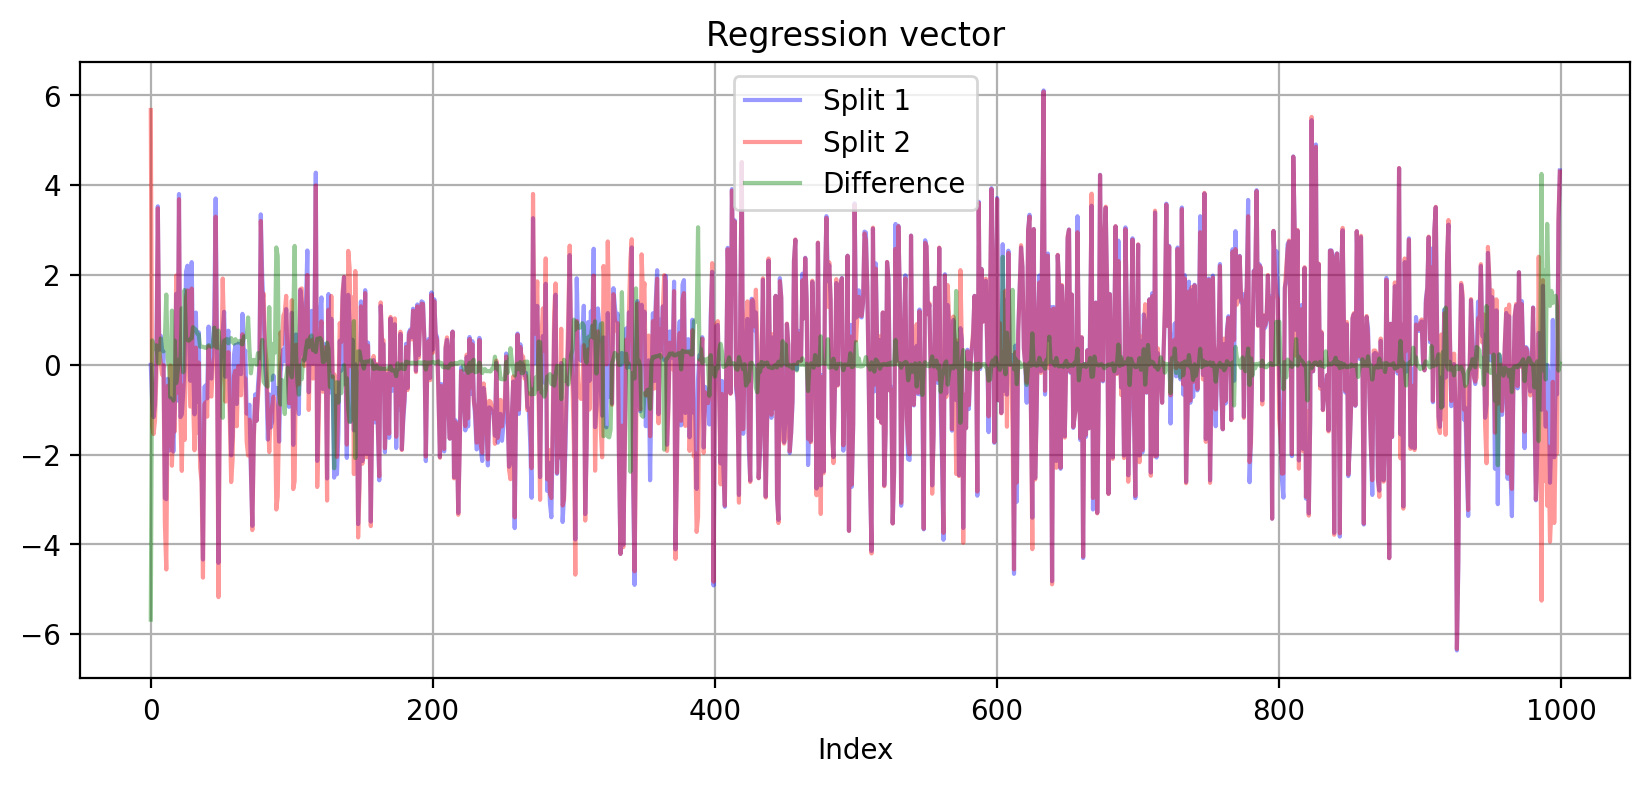

In [40]:
plt.figure(figsize=(10,4),dpi=200)
plt.plot(res3['param'][0],label="Split 1",alpha=0.4,color='blue')
plt.plot(res4['param'][0],label="Split 2",alpha=0.4,color='red')
plt.plot(res3['param'][0]-res4['param'][0],label="Difference",alpha=0.4,color='green')
plt.grid()
plt.title('Regression vector')
plt.xlabel('Index')
plt.legend()

In [51]:
max_iter = 50000
log_iter = 5000
lr = 1.5

# res1 = regression(logits_1, targets_1, max_iter=max_iter, lr=lr, log_iter=log_iter, verbose=True)
# res2 = regression(logits_2, targets_2, max_iter=max_iter, lr=lr, log_iter=log_iter, verbose=True)
res1 = regression_scipy(logits_1, targets_1, max_iter=max_iter, log_iter=log_iter, verbose=True)
res2 = regression_scipy(logits_2, targets_2, max_iter=max_iter, lr=lr, log_iter=log_iter, verbose=True)


Starting Scipy optimization...


/tmp/ipykernel_1283/2477730859.py:51: OptimizeWarning: Unknown solver options: xatol
  result = scipy.optimize.minimize(


Scipy optimization finished: Success=True, Status=0, Message=CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Final Loss = 0.6685484962347258, Final Accuracy = 0.84432
Starting Scipy optimization...
Scipy optimization finished: Success=True, Status=0, Message=CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Final Loss = 0.6679739223246114, Final Accuracy = 0.84184


KeyError: 'loss_his'

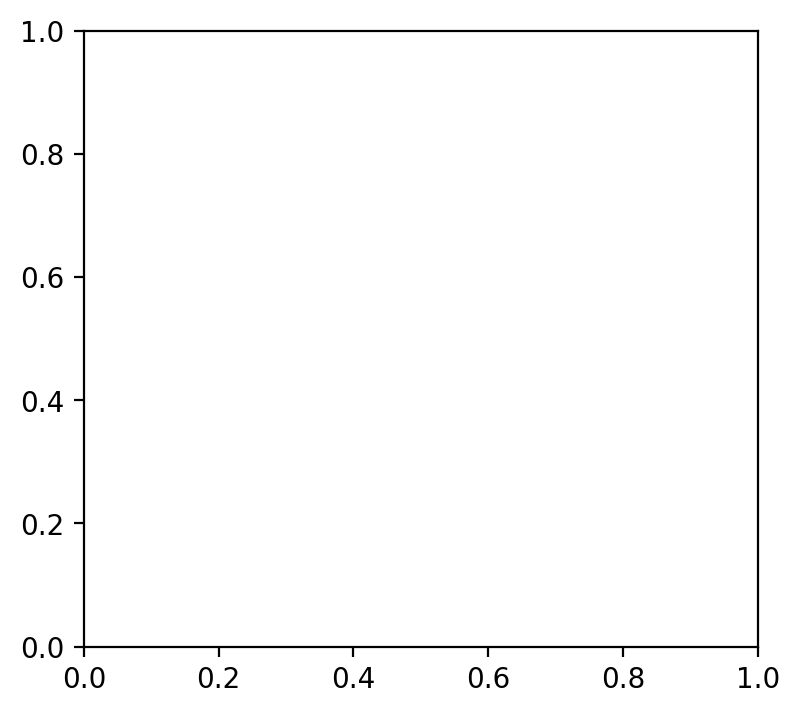

In [52]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,4,1)
plt.plot(res1['loss_his'])
plt.plot(res2['loss_his'])
plt.grid()
plt.title('Loss')
plt.xlabel('Iteration')
plt.subplot(1,4,2)
max_iter = 50000
log_iter = 5000
log_iters = torch.arange(0, max_iter, log_iter)
plt.plot(log_iters,res1['max_his'])
plt.plot(log_iters,res2['max_his'])
plt.grid()
plt.title('Max vector weight')
plt.subplot(1,4,3)
plt.plot(log_iters,res1['acc_his'])
plt.plot(log_iters,res3['acc_his'])
plt.grid()
plt.title('Top-1 accuracy')
plt.xlabel('Iteration')
plt.subplot(1,4,4)
plt.plot(np.sort(res1['param'][0]),label="Split 1")
plt.plot(np.sort(res2['param'][0]),label="Split 2")
plt.hlines(torch.mean(logits).cpu().detach().numpy(), 0, logits.shape[1], colors='r', linestyles='dashed',label="Logits mean")
plt.grid()
plt.title('Regression vector')
plt.xlabel('Index')
plt.legend()
plt.show()

nan
0.0
0.0
0.0


/tmp/ipykernel_1283/2381554467.py:6: RuntimeWarning: invalid value encountered in scalar divide
  relative_error = np.sum(np.abs(param1 - param2)) / np.sum(np.abs(param2))


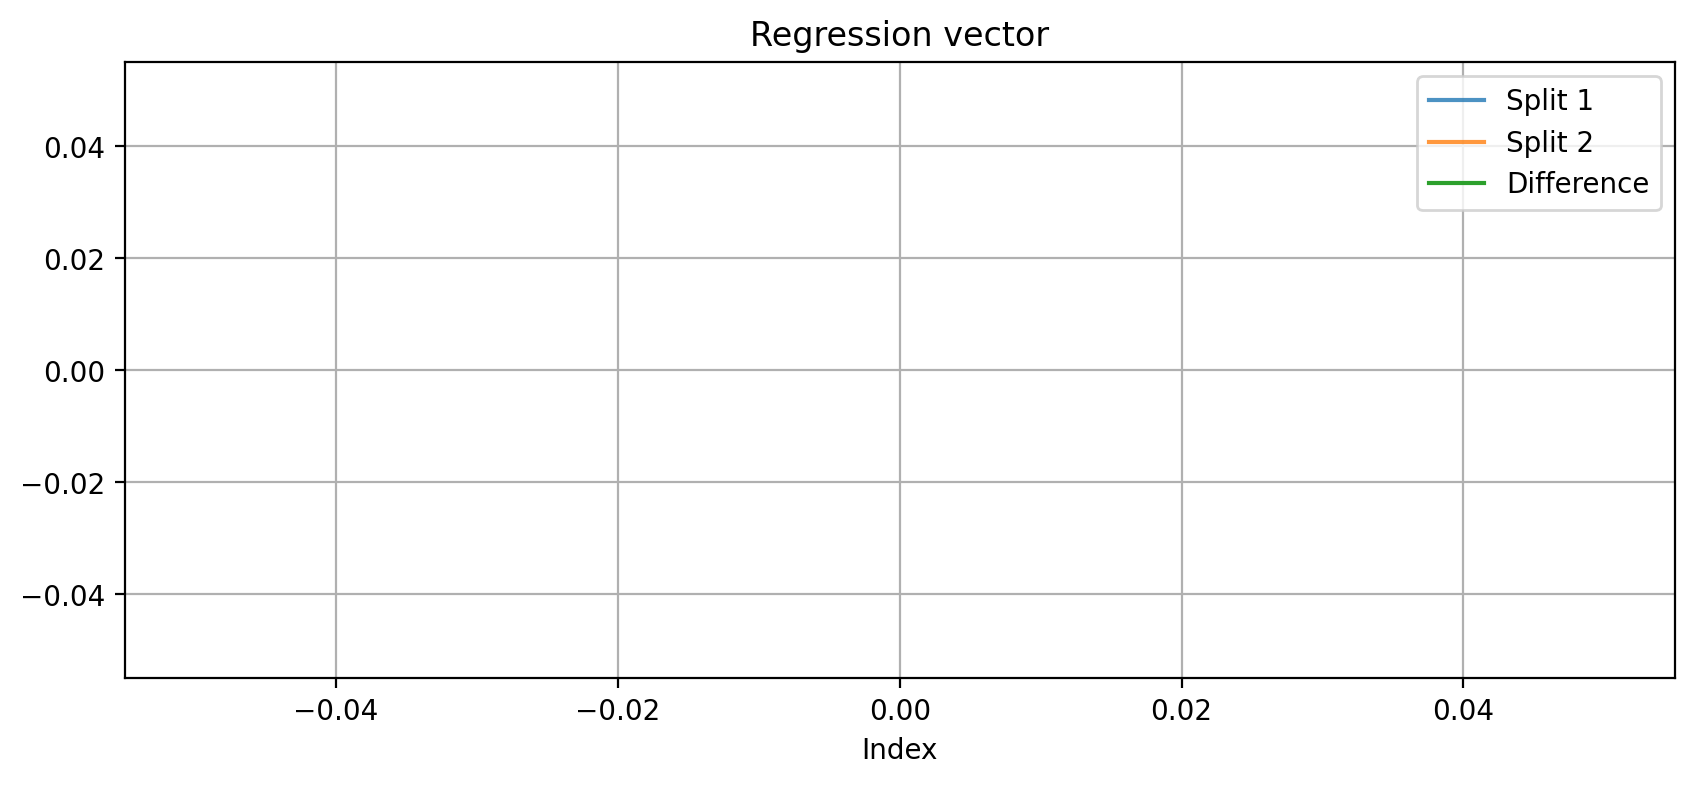

AxisError: axis -1 is out of bounds for array of dimension 0

<Figure size 2000x800 with 0 Axes>

In [53]:
# check the relative error between the two params 
param1 = res1['param'][0]
param2 = res2['param'][0]
param1 = param1 - np.mean(param1) 
param2 = param2 - np.mean(param2) 
relative_error = np.sum(np.abs(param1 - param2)) / np.sum(np.abs(param2))
print(relative_error)
print(np.sum(np.abs(param1 - param2)))
print(np.sum(np.abs(param2)))
print(np.sum(np.abs(param1)))

plt.figure(figsize=(10,4),dpi=200)
plt.plot(param1,label="Split 1",alpha=0.8)
plt.plot(param2,label="Split 2",alpha=0.8)
plt.plot(param1 - param2,label="Difference")
plt.grid()
plt.title('Regression vector')
plt.xlabel('Index')
plt.legend()
plt.show()

plt.figure(figsize=(10,4),dpi=200)
plt.plot(np.sort(param1),label="Split 1",alpha=0.8)
plt.plot(np.sort(param2),label="Split 2",alpha=0.8)
plt.plot(np.sort(param1 - param2),label="Difference")
plt.grid()
plt.title('Regression vector')
plt.xlabel('Index')
plt.legend()
plt.show()



In [10]:
loss_fn = nn.CrossEntropyLoss() 
param1 = torch.tensor(res1['param'][0]).to(logits_1.device)
param2 = torch.tensor(res2['param'][0]).to(logits_2.device)

output_ex1 = loss_fn(logits_1 + param2, targets_1)
output_ex2 = loss_fn(logits_2 + param1, targets_2)

_, pred_ex1 = torch.max(logits_1 + param2, 1)
_, pred_ex2 = torch.max(logits_2 + param1, 1)

acc_ex1 = (pred_ex1 == targets_1).float().mean()
acc_ex2 = (pred_ex2 == targets_2).float().mean()

print(output_ex1.item(), output_ex2.item())
print(acc_ex1.item(), acc_ex2.item())

0.5827676057815552 0.5694289207458496
0.8492400050163269 0.8510400056838989


## Part 3: Unbalanced labels
In this part, we consider the unbalanced labels. This is because the bias should come from the pretraining dataset. It has nothing to do with the evaluation datasets. 

In [3]:
torch.manual_seed(0)
# Create empty lists to store indices for each target class
split_1_indices = []
split_2_indices = []

# For each target class (0-999)
for target in range(1000):
    # Get indices for this target class
    target_indices = torch.where(targets == target)[0]
    # Shuffle these indices
    shuffled_indices = target_indices[torch.randperm(len(target_indices))]
    # Split equally
    half_point = torch.randint(10,len(shuffled_indices)-10,size=(1,)).item()
    # Add to respective splits
    split_1_indices.append(shuffled_indices[:half_point])
    split_2_indices.append(shuffled_indices[half_point:])

# Concatenate all indices for each split
split_1 = torch.cat(split_1_indices)
split_2 = torch.cat(split_2_indices)

# Get the corresponding logits and targets
logits_1 = logits[split_1]
logits_2 = logits[split_2]
targets_1 = targets[split_1]
targets_2 = targets[split_2]

print(logits_1.shape)
print(logits_2.shape)
print(targets_1.shape)
print(targets_2.shape)
print(torch.sum(targets_1==0))
print(torch.sum(targets_2==0))


torch.Size([24795, 1000])
torch.Size([25205, 1000])
torch.Size([24795])
torch.Size([25205])
tensor(11, device='cuda:0')
tensor(39, device='cuda:0')


In [4]:
max_iter = 50000
log_iter = 5000
lr = 1.5

res1 = regression(logits_1, targets_1, max_iter=max_iter, lr=lr, log_iter=log_iter, verbose=True)
res2 = regression(logits_2, targets_2, max_iter=max_iter, lr=lr, log_iter=log_iter, verbose=True)

Iteration 0: Loss = 0.683079719543457, std = 0.01795264706015587, min = 0.0, max = 0.06343929469585419, acc = 0.8417019844055176
Iteration 5000: Loss = 0.5604068040847778, std = 0.8703634738922119, min = 0.0, max = 8.205120086669922, acc = 0.858076274394989
Iteration 10000: Loss = 0.5416212677955627, std = 1.1869680881500244, min = 0.0, max = 10.661885261535645, acc = 0.8603751063346863
Iteration 15000: Loss = 0.5342522859573364, std = 1.3707456588745117, min = 0.0, max = 11.491100311279297, acc = 0.8619076609611511
Iteration 20000: Loss = 0.5304443836212158, std = 1.4962133169174194, min = 0.0, max = 11.830373764038086, acc = 0.8622706532478333
Iteration 25000: Loss = 0.5281789302825928, std = 1.5888208150863647, min = 0.0, max = 12.274503707885742, acc = 0.8621900081634521
Iteration 30000: Loss = 0.5266897082328796, std = 1.6609724760055542, min = 0.0, max = 12.54311752319336, acc = 0.8625529408454895
Iteration 35000: Loss = 0.5256410241127014, std = 1.7194843292236328, min = 0.0, ma

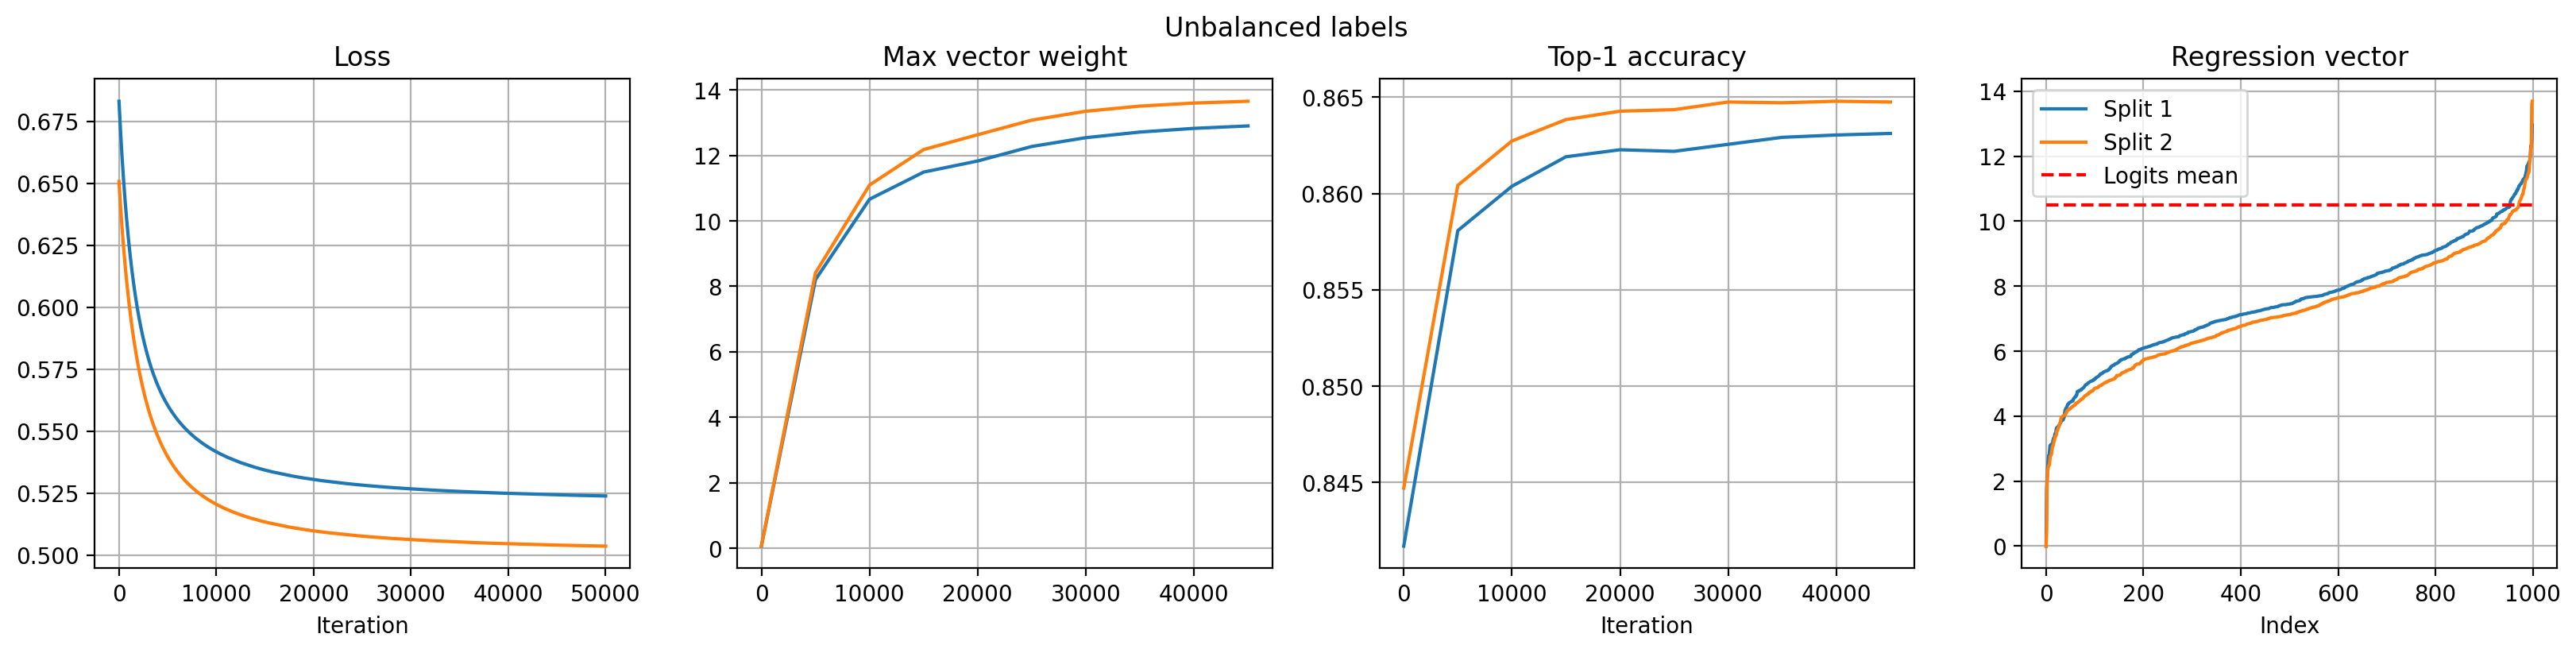

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,4,1)
plt.plot(res1['loss_his'])
plt.plot(res2['loss_his'])
plt.grid()
plt.title('Loss')
plt.xlabel('Iteration')
plt.subplot(1,4,2)
max_iter = 50000
log_iter = 5000
log_iters = torch.arange(0, max_iter, log_iter)
plt.plot(log_iters,res1['max_his'])
plt.plot(log_iters,res2['max_his'])
plt.grid()
plt.title('Max vector weight')
plt.subplot(1,4,3)
plt.plot(log_iters,res1['acc_his'])
plt.plot(log_iters,res2['acc_his'])
plt.grid()
plt.title('Top-1 accuracy')
plt.xlabel('Iteration')
plt.subplot(1,4,4)
plt.plot(np.sort(res1['param'][0]),label="Split 1")
plt.plot(np.sort(res2['param'][0]),label="Split 2")
plt.hlines(torch.mean(logits).cpu().detach().numpy(), 0, logits.shape[1], colors='r', linestyles='dashed',label="Logits mean")
plt.grid()
plt.title('Regression vector')
plt.xlabel('Index')
plt.legend()
plt.suptitle(f"Unbalanced labels")
plt.show()

0.18148685
1299.5256
7160.44
7515.043


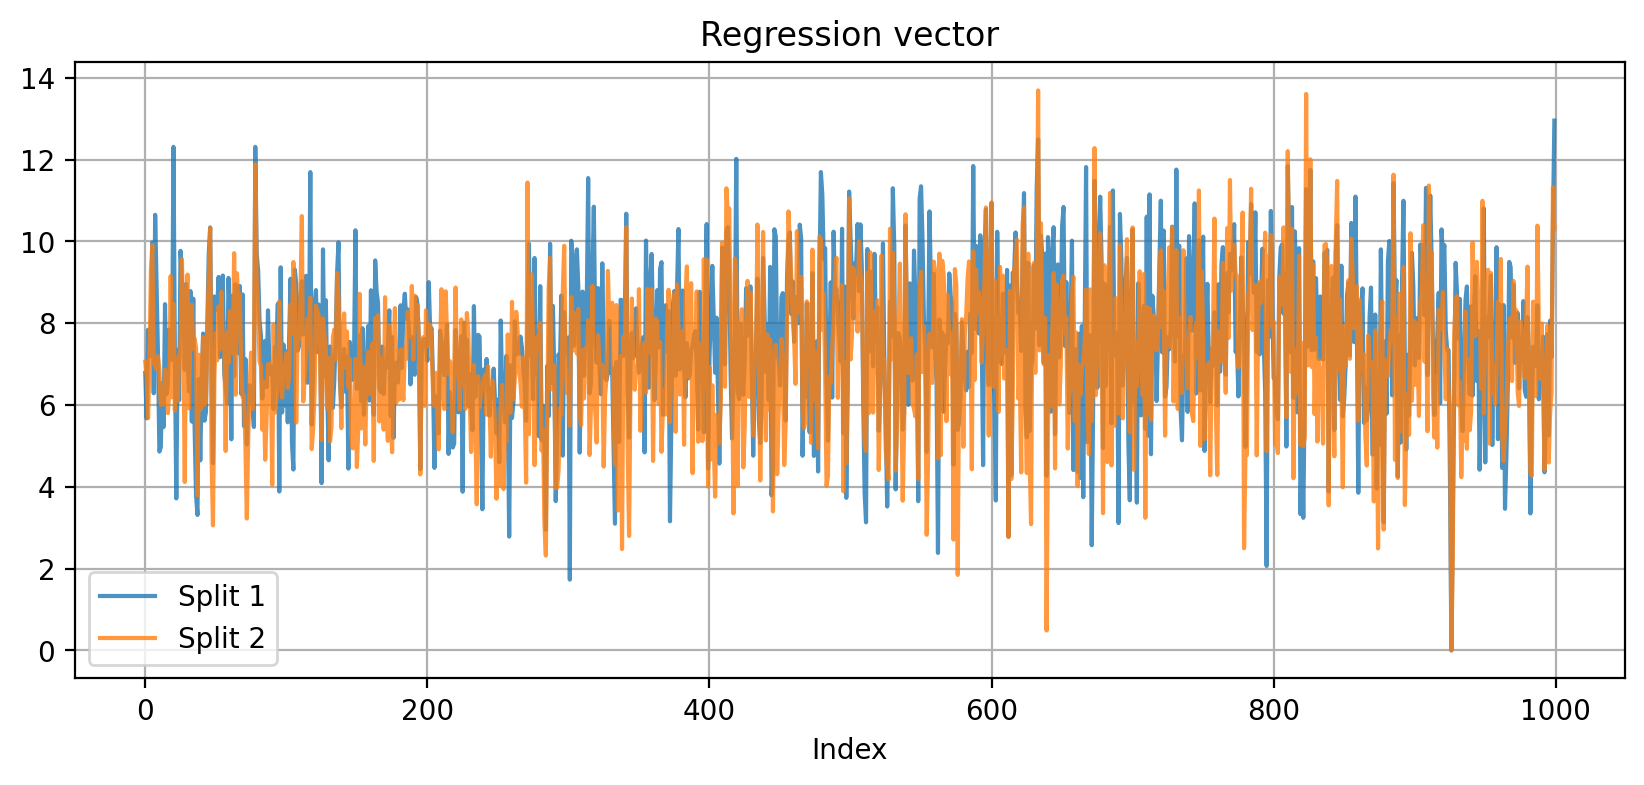

In [6]:
# check the relative error between the two params 
param1 = res1['param'][0]
param2 = res2['param'][0]
# param1 = param1 - np.mean(param1) 
# param2 = param2 - np.mean(param2) 
relative_error = np.sum(np.abs(param1 - param2)) / np.sum(np.abs(param2))
print(relative_error)
print(np.sum(np.abs(param1 - param2)))
print(np.sum(np.abs(param2)))
print(np.sum(np.abs(param1)))

plt.figure(figsize=(10,4),dpi=200)
plt.plot(param1,label="Split 1",alpha=0.8)
plt.plot(param2,label="Split 2",alpha=0.8)
# plt.plot(param1 - param2,label="Difference")
plt.grid()
plt.title('Regression vector')
plt.xlabel('Index')
plt.legend()
plt.show()

In [15]:
# Excange evaluation 

loss_fn = nn.CrossEntropyLoss() 
param1 = torch.tensor(res1['param'][0]).to(logits_1.device)
param2 = torch.tensor(res2['param'][0]).to(logits_2.device)

output_ex1 = loss_fn(logits_1 + param2, targets_1)
output_ex2 = loss_fn(logits_2 + param1, targets_2)

_, pred_ex1 = torch.max(logits_1 + param2, 1)
_, pred_ex2 = torch.max(logits_2 + param1, 1)

acc_ex1 = (pred_ex1 == targets_1).float().mean()
acc_ex2 = (pred_ex2 == targets_2).float().mean()

print(output_ex1.item(), output_ex2.item())
print(acc_ex1.item(), acc_ex2.item())

0.6389379501342773 0.6156268119812012
0.8353700637817383 0.8388811945915222
